In [44]:
from dnn import pipeline
import os
import tensorflow as tf
from tensorflow.contrib.data import shuffle_and_repeat, batch_and_drop_remainder
from tensorflow.errors import InvalidArgumentError, OutOfRangeError

In [3]:
import matplotlib.pyplot as plt

In [4]:
data_dir = "/project/foster/clouds/nasa_laads/mod06_l2/order501256920/"
meta_json = "jsons3/MOD06_L2.A2017001.1850.061.2017312170757.json"
hdf_fields = ['Cloud_Optical_Thickness', 'Cloud_Effective_Radius', 'Cirrus_Reflectance']
data_files = ["records3/MOD06_L2.A2017001.1850.061.2017312170757.tfrecord"]
shape = (64, 64)
batch_size = 32

meta_json = os.path.join(data_dir, meta_json)
data_files = [os.path.join(data_dir, f) for f in data_files]

In [ ]:
records = os.listdir(data_dir + "/records3")
records = [
    (r, r.replace("/records3", "/jsons3").replace(".tfrecord", ".json"))
    for r in records
]







In [41]:
def get_one_sample(f):
    data_files = [f]
    def not_all_same(x):
        return tf.reduce_any(tf.not_equal(x, x[0,0,0]))

    chans, parser = pipeline.hdf_tfr_fn(hdf_fields, meta_json)
    dataset = (
        tf.data.Dataset.from_tensor_slices(data_files)
    #     .apply(shuffle_and_repeat(100))
        .flat_map(tf.data.TFRecordDataset)
        .map(parser)
        .interleave(pipeline.patchify_fn(*shape[:2], chans), cycle_length=4)
        .filter(not_all_same)
    #     .shuffle(10000)
        .apply(batch_and_drop_remainder(batch_size))
    )

    x = dataset.make_one_shot_iterator().get_next()
    with tf.Session() as sess:
        y = sess.run(x)
    return y


In [47]:
empty = []
errs = []
iargs = []
samples = {}
for x in os.listdir(data_dir + "/records3"):
    x = os.path.join(data_dir , "records3", x)
    name = x.split("/")[-1].replace(".tfrecord", "")
    try:
        samples[x] = get_one_sample(x)
        print(name, "Is okay")
    except OutOfRangeError as e:
        print(name, "Has no clouds")
        empty.append(x)
    except InvalidArgumentError as e:
        print(name, "Can't be parsed")
        iargs.append(x)


MOD06_L2.A2017001.0615.061.2017312164229 Has no clouds
MOD06_L2.A2017001.1720.061.2017312171925 Is okay
MOD06_L2.A2017001.0120.061.2017312163833 Has no clouds
MOD06_L2.A2017001.1850.061.2017312170757 Is okay
MOD06_L2.A2017001.1400.061.2017312170659 Can't be parsed
MOD06_L2.A2017001.0255.061.2017312163752 Has no clouds
MOD06_L2.A2017001.0625.061.2017312163945 Has no clouds
MOD06_L2.A2017001.1855.061.2017312171840 Is okay
MOD06_L2.A2017001.1530.061.2017312171445 Is okay
MOD06_L2.A2017001.0115.061.2017312163804 Has no clouds
MOD06_L2.A2017001.0620.061.2017312163953 Has no clouds
MOD06_L2.A2017001.1220.061.2017312171239 Is okay
MOD06_L2.A2017001.0125.061.2017312163816 Can't be parsed
MOD06_L2.A2017001.1900.061.2017312172902 Is okay
MOD06_L2.A2017001.0755.061.2017312164325 Has no clouds
MOD06_L2.A2017001.0445.061.2017312163932 Has no clouds
MOD06_L2.A2017001.1715.061.2017312171534 Is okay
MOD06_L2.A2017001.1350.061.2017312173112 Is okay
MOD06_L2.A2017001.1535.061.2017312171139 Is okay
MOD06

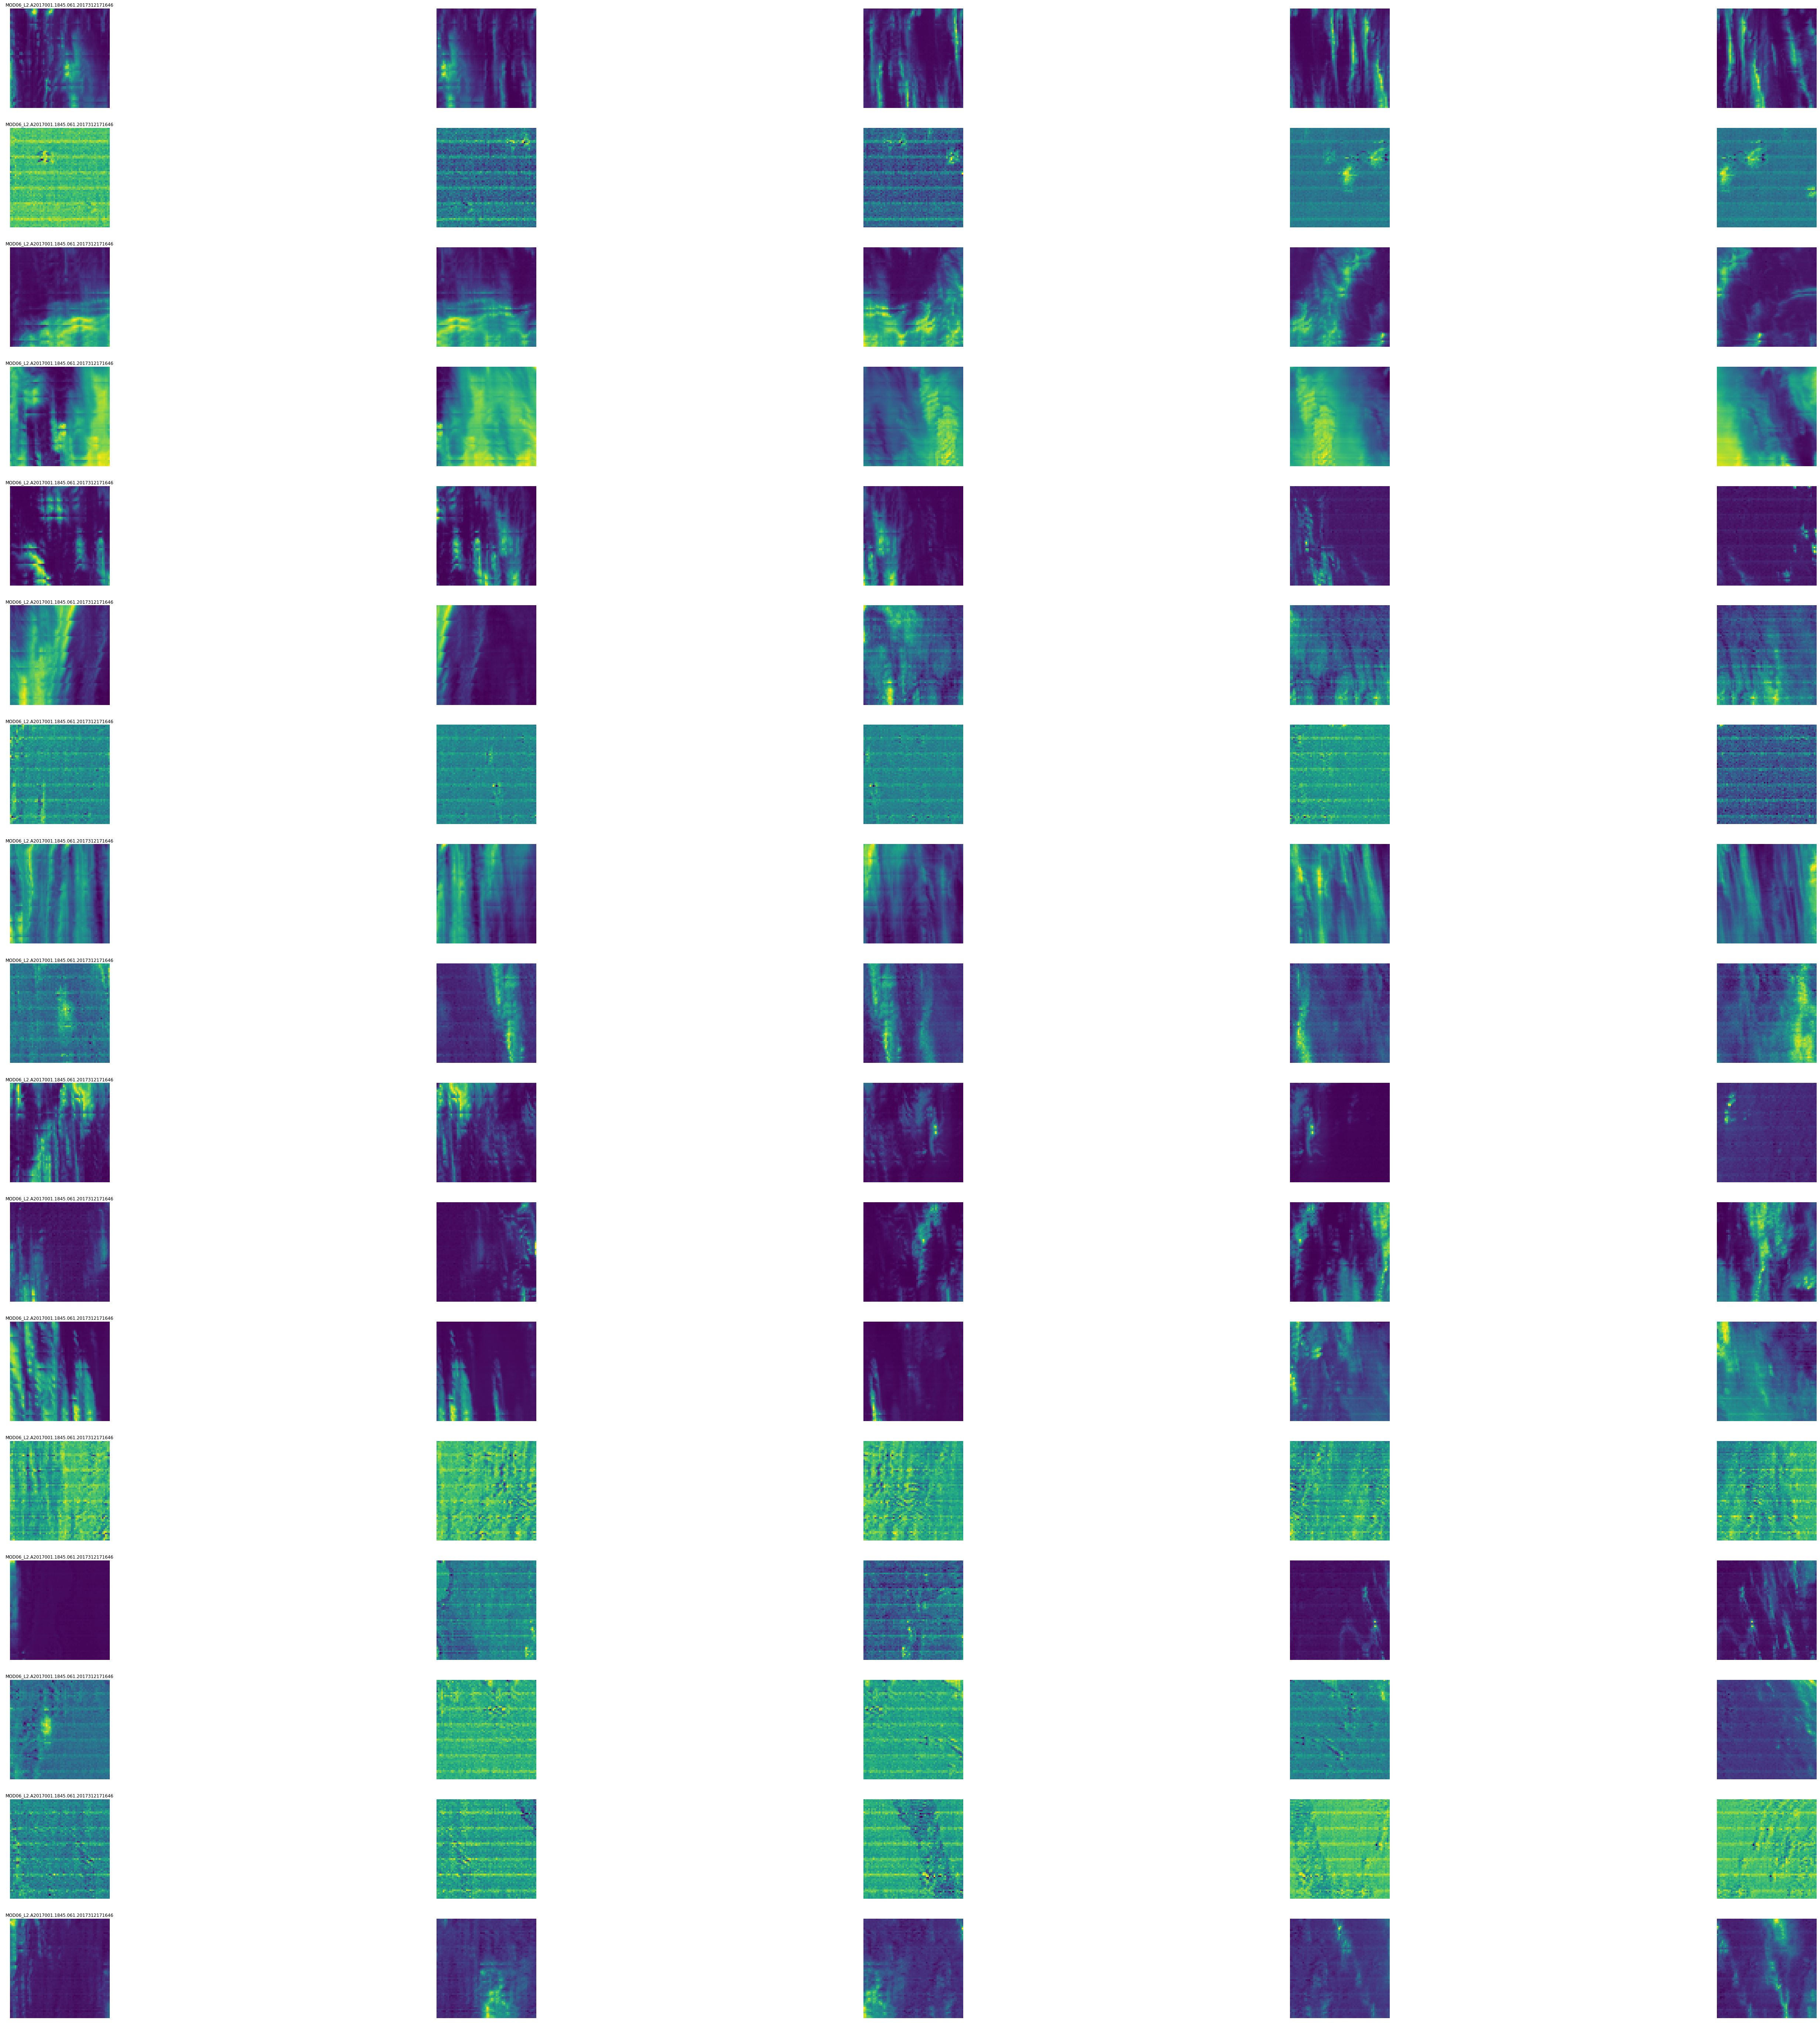

In [48]:
fig, ax = plt.subplots(nrows=17, ncols=5, figsize=(100, 100))

for i, k in enumerate(samples):
    for col in range(5):
        a = ax[i, col]
        if col == 0:
            name = x.split("/")[-1].replace(".tfrecord","")
            a.set_title(name)
        a.axis("off")
        a.imshow(samples[k][col,:,:,0])

fig.savefig("cloud-optical-thickness-hdf-samples.png")